In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


import os
from random import shuffle
import matplotlib.pyplot as plt
import glob
import imageio
import PIL
import time

from IPython import display
from tqdm.notebook import tqdm

In [2]:
class Data_cooker:
    def __init__(self):
        self.temperature_list = None
        self.lattice_set = []
        self.int_temps = []
        self.train_labels = None
        self.train_dataset = None
        self.mapping = {}
        
    def _retrieve_lattice_data(self):
        pbar = tqdm(range(15000))
        pbar.set_description('Retrieving lattice data')
        for i in range(15000):
            fpath = './dataset/lattice_data/lattice_{}.csv'.format(i+1) 
            lattice = pd.read_csv(fpath, header=None).dropna(axis=1).to_numpy()
            self.lattice_set.append(lattice)
            pbar.update(1)
        
        pbar.close()
        self.lattice_set = np.stack(self.lattice_set, axis=0).reshape(-1, 100, 100, 1)
        
    def _retrieve_temperature_labels(self, visualise=True):
        self.temperature_list = np.loadtxt('./dataset/temperature_record.csv')
        
        for i in range(len(self.temperature_list)):
            self.temperature_list[i] = round(self.temperature_list[i], 2)
        
        if visualise == True: 
            plt.hist(self.temperature_list, bins=250);
            plt.show();
            
    def _prepare_one_hot_labels(self):
        temp_labels = sorted(np.unique(self.temperature_list))
        int_labels = np.arange(0, len(temp_labels), 1)
        

        for key, value in zip(temp_labels, int_labels):
            self.mapping[key] = value
            
        for T in self.temperature_list:
            self.int_temps.append(self.mapping[T])
            
        self.train_labels = tf.keras.utils.to_categorical(self.int_temps, len(temp_labels))
        
    def cook_data(self):
        self._retrieve_lattice_data()
        self._retrieve_temperature_labels(visualise=True)
        self._prepare_one_hot_labels()
        self.lattice_set = self.lattice_set.astype(dtype='float32')
        
        return self.lattice_set, self.train_labels, self.mapping
    
    def make_dataset(self, buffer_size=15000, batch_size=128):
        BUFFER_SIZE = buffer_size
        BATCH_SIZE = batch_size
        self.train_dataset = tf.data.Dataset.from_tensor_slices((self.lattice_set
                                                            ,self.train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
        return self.train_dataset

  0%|          | 0/15000 [00:00<?, ?it/s]

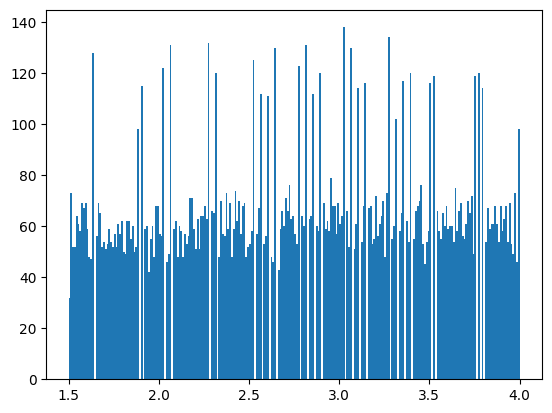

{'1.5': '0', '1.51': '1', '1.52': '2', '1.53': '3', '1.54': '4', '1.55': '5', '1.56': '6', '1.57': '7', '1.58': '8', '1.59': '9', '1.6': '10', '1.61': '11', '1.62': '12', '1.63': '13', '1.64': '14', '1.65': '15', '1.66': '16', '1.67': '17', '1.68': '18', '1.69': '19', '1.7': '20', '1.71': '21', '1.72': '22', '1.73': '23', '1.74': '24', '1.75': '25', '1.76': '26', '1.77': '27', '1.78': '28', '1.79': '29', '1.8': '30', '1.81': '31', '1.82': '32', '1.83': '33', '1.84': '34', '1.85': '35', '1.86': '36', '1.87': '37', '1.88': '38', '1.89': '39', '1.9': '40', '1.91': '41', '1.92': '42', '1.93': '43', '1.94': '44', '1.95': '45', '1.96': '46', '1.97': '47', '1.98': '48', '1.99': '49', '2.0': '50', '2.01': '51', '2.02': '52', '2.03': '53', '2.04': '54', '2.05': '55', '2.06': '56', '2.07': '57', '2.08': '58', '2.09': '59', '2.1': '60', '2.11': '61', '2.12': '62', '2.13': '63', '2.14': '64', '2.15': '65', '2.16': '66', '2.17': '67', '2.18': '68', '2.19': '69', '2.2': '70', '2.21': '71', '2.22': '

In [3]:
dc = Data_cooker()
lattice_set, train_labels, label_mapping = dc.cook_data()
train_dataset = dc.make_dataset()

with open('label_mapping.txt', 'w') as file:
    for key, value in label_mapping.items():
        file.write(f"{key}: {value}\n")


restored_dict = {}
with open('label_mapping.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        restored_dict[key] = value

print(restored_dict)


In [4]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.input_x = tf.keras.layers.InputLayer(input_shape=(100,100, 1), name='lattice_input')
        self.conv1 = tf.keras.layers.Conv2D(16, (5, 5), strides=(5, 5), padding='same')
        self.leaky_relu1 = tf.keras.layers.LeakyReLU()
        self.dropout1 = tf.keras.layers.Dropout(0.3)
        
        self.conv2 = tf.keras.layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same')
        self.leaky_relu2 = tf.keras.layers.LeakyReLU()
        self.dropout2 = tf.keras.layers.Dropout(0.3)
        
        self.input_y = tf.keras.layers.InputLayer(input_shape=(251,), name='label_input')
        self.dense1 = tf.keras.layers.Dense(1024)
        self.leaky_relu3 = tf.keras.layers.LeakyReLU()

        self.dense2 = tf.keras.layers.Dense(10*10*128)
        self.leaky_relu4 = tf.keras.layers.LeakyReLU()
        self.batch_norm = tf.keras.layers.BatchNormalization()

        self.reshape = tf.keras.layers.Reshape((10, 10, 128))

        self.flatten = tf.keras.layers.Flatten()
        self.dense3 = tf.keras.layers.Dense(1024)
        self.leaky_relu5 = tf.keras.layers.LeakyReLU()

        self.out = tf.keras.layers.Dense(1)
        
        self.loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        
        self.real_loss = None
        self.generated_loss = None
        self.total_loss = None
        
        self.real_loss_log = []
        self.generated_loss_log = []
        self.total_loss_log = []

    def call(self, inputs, training=False):
        x, y = inputs
        
        x = self.input_x(x)
        x = self.conv1(x)
        x = self.leaky_relu1(x)
        x = self.dropout1(x, training=training)

        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.dropout2(x, training=training)
        
        y = self.input_y(y)
        y = self.dense1(y)
        y = self.leaky_relu3(y)

        y = self.dense2(y)
        y = self.leaky_relu4(y)
        y = self.batch_norm(y, training=training)

        y = self.reshape(y)

        xy = tf.concat([x, y], axis=-1)

        xy = self.flatten(xy)
        xy = self.dense3(xy)
        xy = self.leaky_relu5(xy)

        return self.out(xy)
    
    def loss(self, real_output, generated_output):
    
        self.real_loss = self.loss_function(tf.ones_like(real_output), real_output)

        self.generated_loss = self.loss_function(tf.zeros_like(generated_output), generated_output)

        self.total_loss = self.real_loss + self.generated_loss
        
        self.total_loss_log.append(self.total_loss)
        self.real_loss_log.append(self.real_loss)
        self.generated_loss_log.append(self.generated_loss)

        return self.total_loss


In [5]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.input_x = tf.keras.layers.InputLayer(input_shape=(100,), name='noise_input')
        self.dense1 = tf.keras.layers.Dense(50*50*256, use_bias=False)
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu1 = tf.keras.layers.LeakyReLU()
        
        self.reshape_x = tf.keras.layers.Reshape((50, 50, 256))
        
        self.input_y = tf.keras.layers.InputLayer(input_shape=(251,), name='label_input')
        self.dense2 = tf.keras.layers.Dense(50*50*128, use_bias=False)
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.leaky_relu2 = tf.keras.layers.LeakyReLU()
        
        self.reshape_y = tf.keras.layers.Reshape((50, 50, 128))
        
        self.transpose_conv1 = tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(1, 1), padding='same', use_bias=False)
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.leaky_relu3 = tf.keras.layers.LeakyReLU()

        self.transpose_conv2 = tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2, 2), padding='same', use_bias=False)
        self.batch_norm4 = tf.keras.layers.BatchNormalization()
        self.leaky_relu4 = tf.keras.layers.LeakyReLU()
        
        self.out = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')

        self.loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.loss_log = []
        
    def call(self, inputs, training=False):
        x, y = inputs
        
        x = self.input_x(x)
        x = self.dense1(x)
        x = self.batch_norm1(x, training=training)
        x = self.leaky_relu1(x)
        x = self.reshape_x(x)
        
        y = self.input_y(y)
        y = self.dense2(y)
        y = self.batch_norm2(y, training=training)
        y = self.leaky_relu2(y)
        y = self.reshape_y(y)
        
        xy = tf.concat([x, y], axis=-1)
        
        xy = self.transpose_conv1(xy)
        xy = self.batch_norm3(xy, training=training)
        xy = self.leaky_relu3(xy)
        
        xy = self.transpose_conv2(xy)
        xy = self.batch_norm4(xy, training=training)
        xy = self.leaky_relu4(xy)
        
        return self.out(xy)

    def loss(self, generated_output):
        loss_value = self.loss_function(tf.ones_like(generated_output), generated_output)
        self.loss_log.append(loss_value)
        return loss_value

In [37]:
class cGAN_Ising:
    def __init__(self):
        self.train_dataset = None
        self.discriminator = Discriminator()
        self.generator = Generator()
        self.generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        self.random_seed = tf.random.normal([251, 100])
        self.labels_to_generate = tf.keras.utils.to_categorical(np.arange(0, 251, 1), 251)
        self.checkpoint_prefix = os.path.join('./training_checkpoints_cGAN', 'ckpt')
        self.checkpoint_dir = './training_checkpoints_cGAN'
        
    def _train_step(self, lattice_set, train_labels):
        current_batch_size = tf.shape(train_labels)[0]
        noise_vector = tf.random.normal([current_batch_size, 100])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator([noise_vector, train_labels], training=True)

            real_output = self.discriminator([lattice_set, train_labels], training=True)
            generated_output = self.discriminator([generated_images, train_labels], training=True)
            
            disc_loss = self.discriminator.loss(real_output, generated_output)
            gen_loss = self.generator.loss(generated_output)
            
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
      
        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
    def train(self, epochs, train_dataset, auto_ckpt=False):
        self._gpu_init()
        self.train_dataset = train_dataset
        
        for epoch in range(epochs):
            ti = time.time()
            pbar = tqdm(range(len(self.train_dataset)))
            pbar.set_description('Epoch {}'.format(epoch+1))
            
            for batch in self.train_dataset: 
                lattices = batch[0]
                labels = batch[1]
                try:
                    self._train_step(lattices, labels)
                except tf.errors.ResourceExhaustedError as e:
                    raise ValueError('Running out of memory.')
                pbar.update(1)
            pbar.close()
            pbar.clear()
            display.clear_output(wait=True)
            
            self.generate_and_save(self.generator, epoch+1, self.random_seed, self.labels_to_generate)
            print ('Time taken for epoch {}: {}s'.format(epoch+1, time.time()-ti))
                                 
                                 
        display.clear_output(wait=True)
        self.checkpoint()
        self.generate_and_save(self.generator, epoch+1, self.random_seed, self.labels_to_generate)
        
        fig, ax = plt.subplots()
        ax.plot(self.generator.loss_log, label='generator loss')
        ax.plot(self.discriminator.total_loss_log, label='discriminator total loss')
        ax.legend()
        ax.grid()
        ax.set_ylabel('Binary Cross Entropy')
                                 
    def generate_and_save(self, model, epoch
                          , random_seed, labels_to_generate):
        
        predictions = model([random_seed, labels_to_generate], training=False)
                                 
        fig = plt.figure(figsize=(40,40))

        for i in range(predictions.shape[0]):
            plt.subplot(16, 16, i+1)
            plt.imshow(tf.where(predictions[i, :, :, 0] < 0, -1, 1), cmap='binary'
                       , extent=(0, 100, 0, 100), vmax = 1, vmin =-1)
            plt.axis('off')
            
        if epoch == None:
            plt.savefig('generated_output.png'.format(epoch))
            plt.show()
            
        else:

            plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
            plt.show()
        
        return np.array(predictions)
        
    def fit(self, temperature, visualise=True):
        mapping = {}
        with open('label_mapping.txt', 'r') as file:
            for line in file:
                key, value = line.strip().split(': ')
                mapping[key] = value
            
        index = int(mapping[str(temperature)])
        
        lattice = self.generator([tf.random.normal([251, 100]), self.labels_to_generate], training=False)[index]
        
        if visualise: 
            plt.imshow(np.where(lattice < 0, -1, 1), cmap='binary'
                       , extent=(0, 100, 0, 100), vmax = 1, vmin =-1)
            plt.title('T = {}'.format(temperature))
        
        return np.array(lattice)
    
    def checkpoint(self):
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                 discriminator_optimizer=self.discriminator_optimizer,
                                 generator=self.generator,
                                 discriminator=self.discriminator)
        checkpoint.save(file_prefix = self.checkpoint_prefix)
        
    def restore_checkpoint(self):
        checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                 discriminator_optimizer=self.discriminator_optimizer,
                                 generator=self.generator,
                                 discriminator=self.discriminator)
        checkpoint.restore(tf.train.latest_checkpoint(self.checkpoint_dir))
        
    def _gpu_init(self):
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                # Currently, memory growth needs to be the same across GPUs
                for gpu in gpus:
                    tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
            except RuntimeError as e:
                # Memory growth must be set before GPUs have been initialized
                print('GPU already initialised.')
        else: print('GPU not detected, work on CPU by default. please check CUDA and CUDNN installation if this is unexpected.')

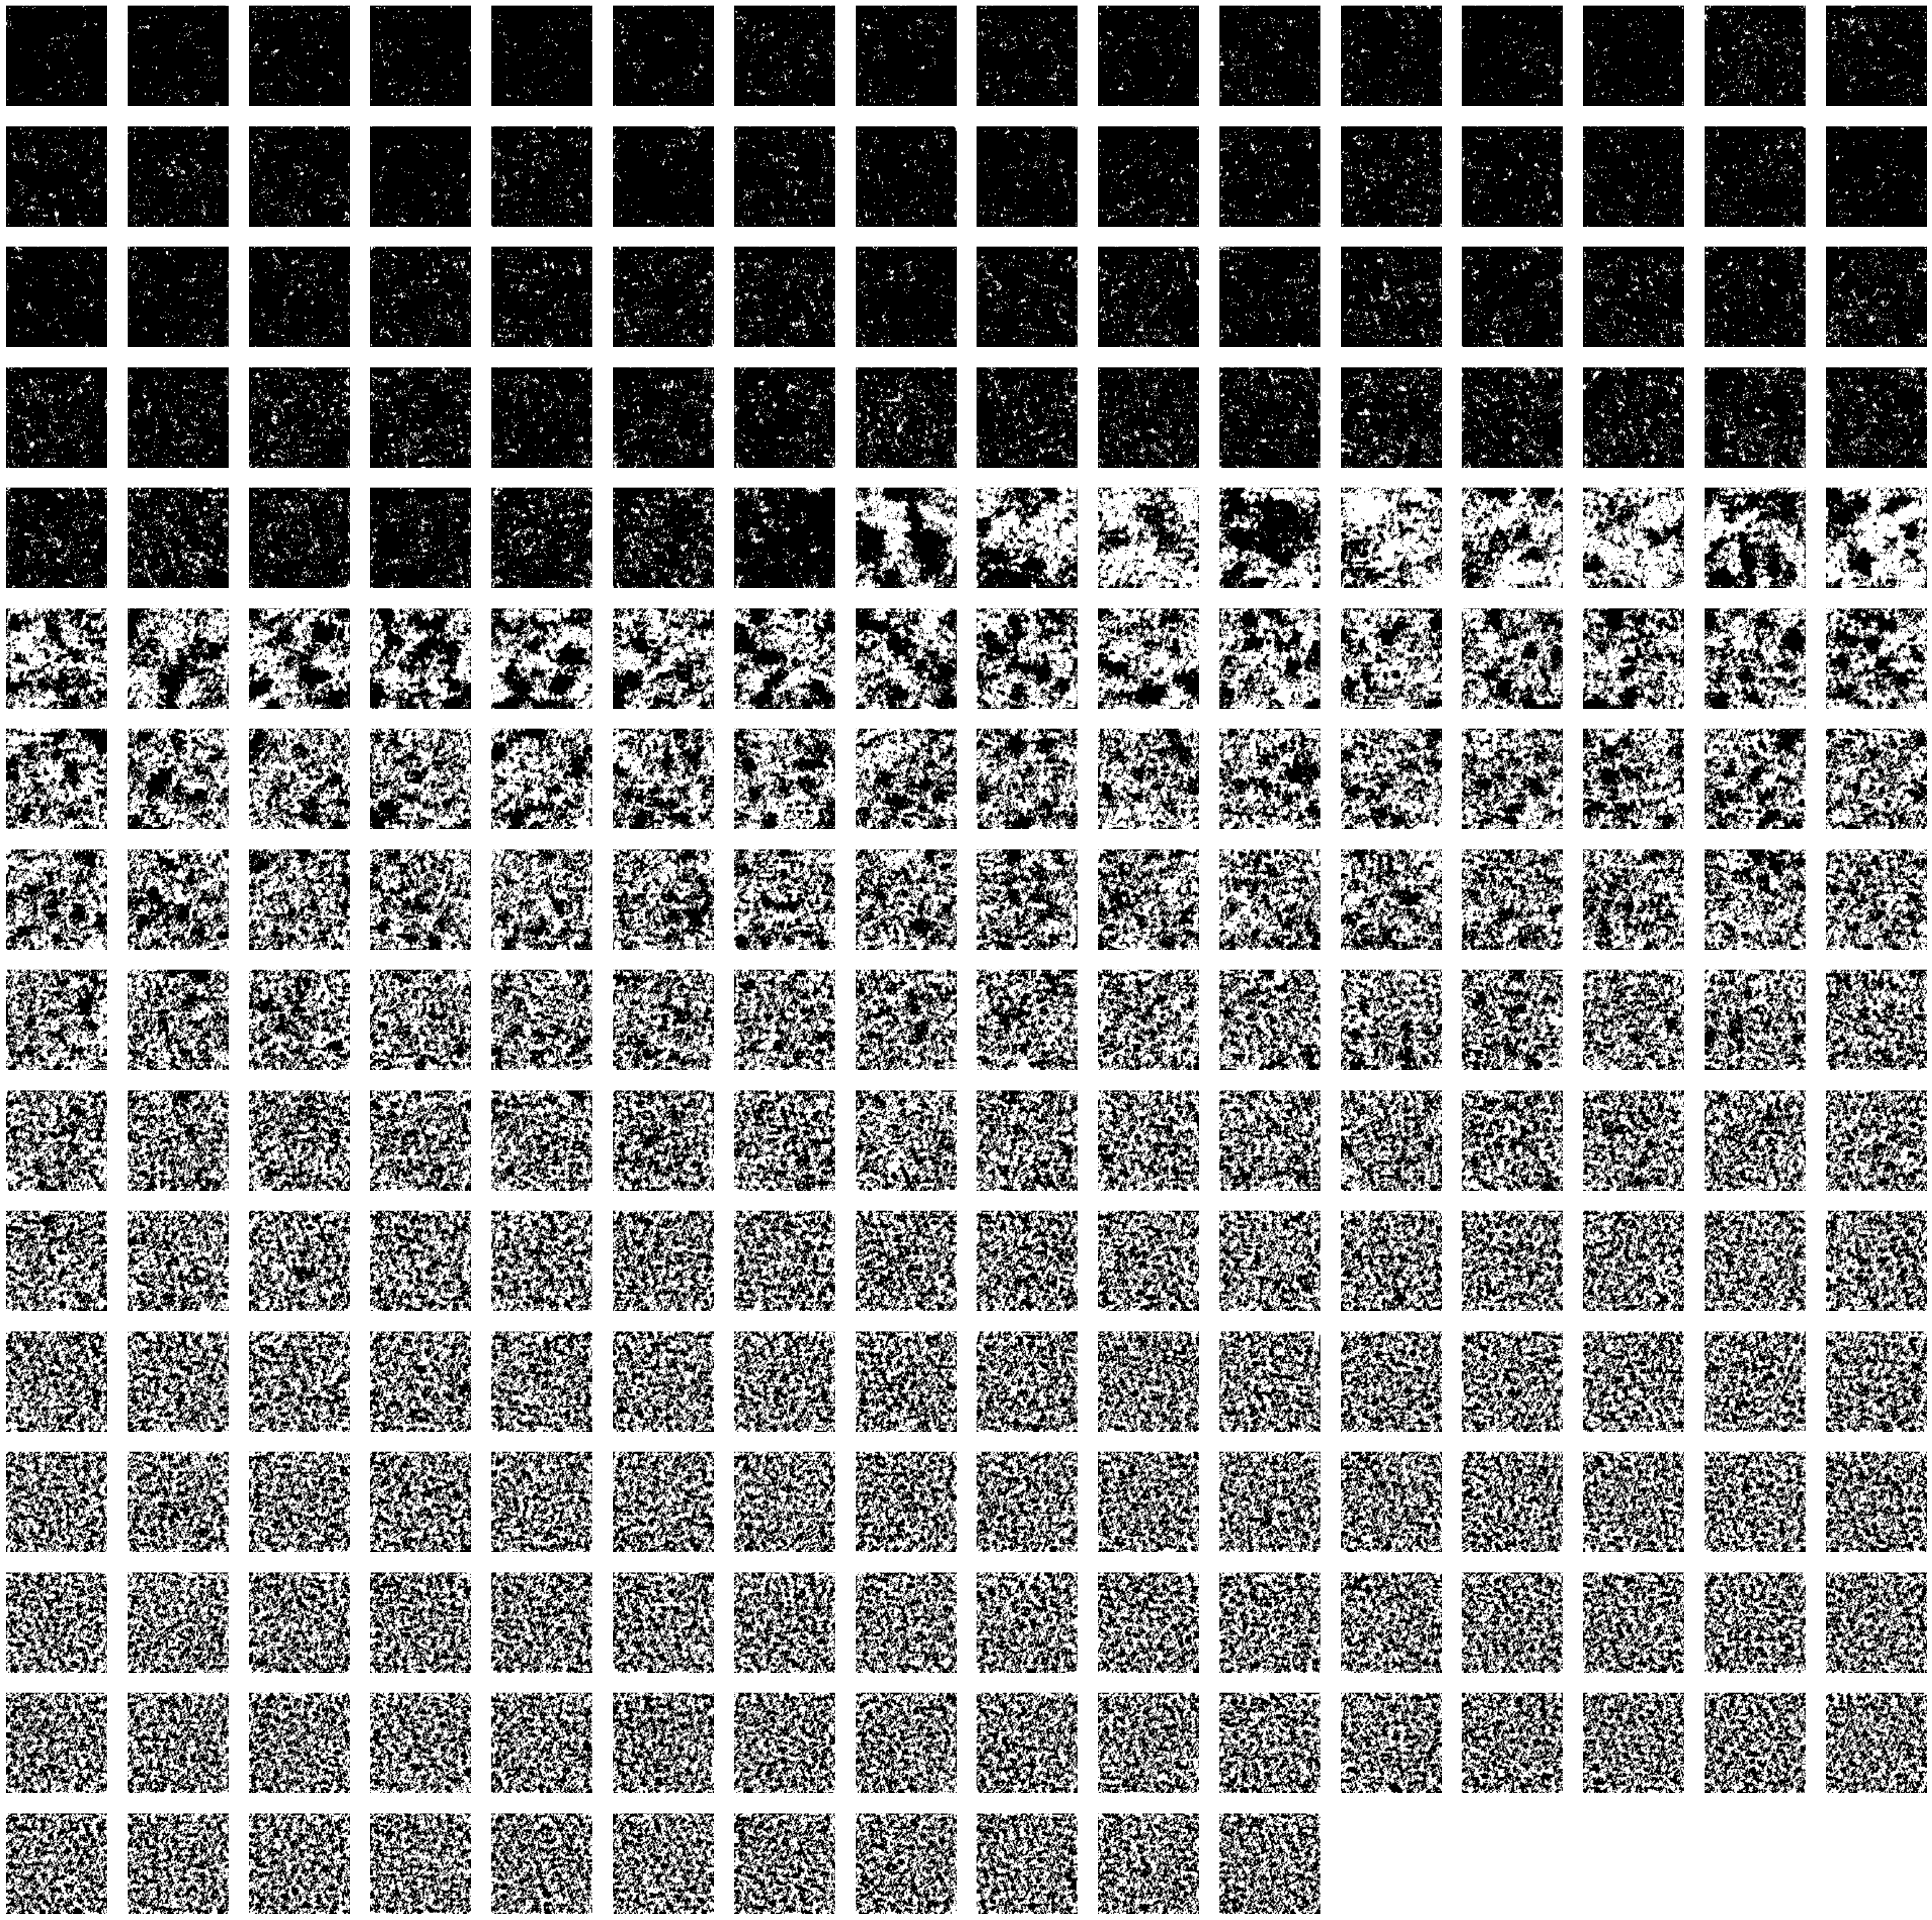

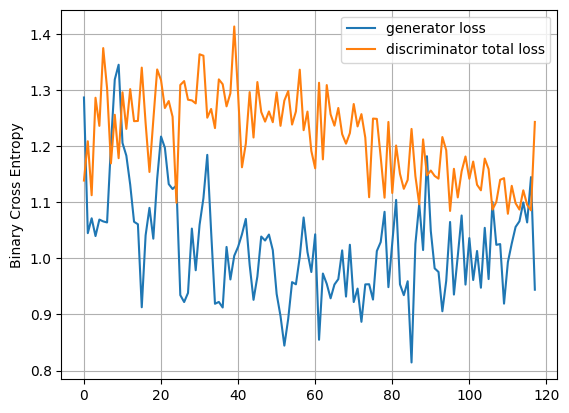

In [58]:
model = cGAN_Ising()
model.restore_checkpoint()
model.train(train_dataset=train_dataset, epochs=1)

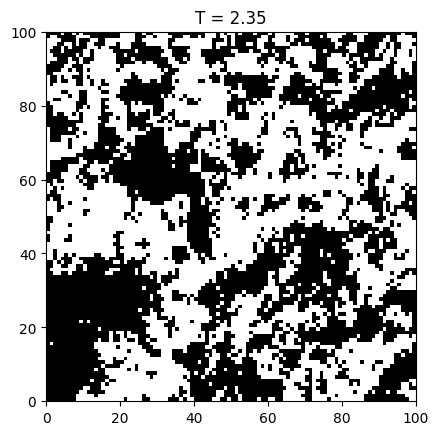

In [59]:
model.fit(2.35);

In [60]:
model.checkpoint()